Steady-state state visual evoked potentials (SSVEP) refers to periodic evoked potentials caused by rapid repetitive visual stimulation, usually at frequencies above 6Hz. It consists of multiple discrete frequency components, including the fundamental frequency of the visual stimulus and its harmonics.

**Import the require library**

pip install os<br/>
pip install mne<br/>
pip install numpy<br/>
pip install scipy<br/>
pip install matplotlib<br/>

In [2]:
import mne
import warnings
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
from Functions import Data_path, Plot_data, Filtering, FFT, Common_average_reference, PSDA_a_trial, PSDA_all_trial

**Step 1.1: Importing pathway files**

In [3]:
# Define the base folder path where the data is located
folder_path = "D:\GitHub\SSVEP-based-EEG-signal-processing\Data" 
path_files, files, folders = Data_path.data_path(folder_path, data_format="gdf") 
path_files

['D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject2-[2012.04.07-19.27.02].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject2-[2012.04.07-19.36.29].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject2-[2012.04.07-19.44.23].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject2-[2012.04.07-19.57.52].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject3-[2012.04.07-18.17.50].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject3-[2012.04.07-18.27.18].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject3-[2012.04.07-18.45.34].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject3-[2012.04.07-18.53.10].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject4-[2012.04.08-16.06.48].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject4-[2012.04.08-16.19.25].gdf',
 'D:\\GitHub\\SSVEP-based-EEG-signal-processing\\Data\\Subject4-[2012.04.08-16.2

**Step 1.2: Load data, channel locations, labels & events**<br/>
[Dataset](https://github.com/sylvchev/dataset-ssvep-led)<br/>
Label_01 ---> 13Hz stimulation (33025)<br/>
Label_02 ---> 21Hz stimulation (33026)<br/>
Label_03 ---> 17Hz stimulation (33027)<br/>
Rest ---> 33024

In [5]:
warnings.filterwarnings("ignore", message="Omitted .* annotation.*")
raw = mne.io.read_raw_gdf(path_files[0], verbose=0)   # Read the data from the GDF file into a raw MNE object
channels_name = raw.ch_names                          # Extract the channel names from the raw data
# Get the EEG data and transpose it to have channels as rows and samples as columns
data = raw.get_data().T                               
fs = raw.info['sfreq']                                # Get the sampling frequency of the EEG data
labels = raw.annotations.description                  # Define labels for each stimulation frequency
# Get the start time of each trial from the annotations
events, event_ind = mne.events_from_annotations(raw, verbose=0)  

In [7]:
print(f"data: {data}, \n channels_name: {channels_name}, \n labels: {labels}, \n events: {events}, \n event_ind: \
{event_ind}")

data: [[ 1.17396582e-08 -4.74957048e-09 -1.26818539e-08 ...  3.03539815e-09
   1.22814473e-08  8.15642478e-09]
 [ 2.38604741e-08  5.03880715e-09 -1.56107228e-09 ...  1.22761669e-08
   2.10623854e-08  1.36445768e-08]
 [ 5.39719351e-09 -5.26715188e-09 -7.16606514e-09 ... -3.61855346e-09
   3.91582377e-09  3.01696753e-09]
 ...
 [ 1.56274671e-08  1.21936088e-08 -7.98376966e-09 ...  5.87641119e-09
   8.58811349e-09  7.09517992e-09]
 [-2.10399069e-09 -6.85034204e-10 -1.61905497e-08 ... -1.11846198e-08
  -7.72781887e-09 -8.94477811e-10]
 [-2.48514842e-09 -4.88657732e-09 -1.41685894e-08 ... -1.23060723e-08
  -4.01965243e-09  2.59246959e-09]], 
 channels_name: ['Oz', 'O1', 'O2', 'PO3', 'POz', 'PO7', 'PO8', 'PO4'], 
 labels: ['32769' '33024' '32779' '32780' '33026' '32779' '32780' '33027' '32779'
 '32780' '33025' '32779' '32780' '33026' '32779' '32780' '33025' '32779'
 '32780' '33024' '32779' '32780' '33027' '32779' '32780' '33025' '32779'
 '32780' '33026' '32779' '32780' '33027' '32779' '32780'

**Step 2.1: Split trials for a single dataset** **(** *e.g., Subject2-[2012.04.07-19.27.02].gdf* **)**

In [8]:
time_trial = 5                          # Define the duration of each trial in seconds
time_start_trial = events[:, 0]         # Extract the start time of each trial from the events
# Calculate the duration of each trial in samples based on the sampling frequency (Fs * time each trial)
duration_trial = int(fs * time_trial)   
lab = ['33025', '33026', '33027']       # Define the labels for the current iteration

data_trials = []
for _, val in enumerate(lab):                      # Loop through the labels of interest
    num_trials = np.where(labels == val)[0] # Find the indices of trials with the current label
    # Initialize an array to store trial data for the current label
    data_trial = np.zeros((duration_trial, len(channels_name), len(num_trials))) 
    for j, trial_index in enumerate(num_trials): # Iterate over each trial index and extract the corresponding data
        data_trial[:, :, j] = data[time_start_trial[trial_index]:time_start_trial[trial_index] + duration_trial, :]
        
    # Using exec to dynamically create variable names for each trial's data array
    data_trials.append(data_trial) 

print(f"data_freq_13Hz: {data_trials[0].shape} \ndata_freq_21Hz: {data_trials[1].shape} \ndata_freq_17Hz:\
 {data_trials[2].shape}")

data_freq_13Hz: (1280, 8, 10) 
data_freq_21Hz: (1280, 8, 10) 
data_freq_17Hz: (1280, 8, 10)


**Step 2.2: Split trials for all datasets or stimulations**

In [9]:
data1, data2, data3 = [], [], []
lab = ['33025', '33026', '33027']       # Define the labels for the current iteration
# Calculate the duration of each trial in samples based on the sampling frequency (Fs * time each trial)
duration_trial = int(fs * time_trial)   
data_list = [data1, data2, data3]       # Initialize a list to store data lists

for i in range(len(path_files)):
    raw = mne.io.read_raw_gdf(path_files[i], verbose=0) # Read the data from the GDF file into a raw MNE object
    fs = raw.info['sfreq']                              # Get the sampling frequency of the EEG data
    # Get the EEG data and transpose it to have channels as rows and samples as columns
    data = raw.get_data().T
    labels = raw.annotations.description                # Define labels for each stimulation frequency
    events, _ = mne.events_from_annotations(raw, verbose=0) # Get the start time of each trial from the annotations
    time_start_trial = events[:, 0]                     # Extract the start time of each trial from the events 
    
    for j, val in enumerate(lab):                                  # Loop through the labels of interest
        num_trials = np.where(labels == val)[0]      # Find the indices of trials with the current label
        # Initialize an array to store trial data for the current label
        data_trial = np.zeros((duration_trial, len(channels_name), len(num_trials)))
        
        # Iterate over each trial index and extract the corresponding data
        for ind, trial_index in enumerate(num_trials):  
            data_trial[:, :, ind] = data[time_start_trial[trial_index]:time_start_trial[trial_index] + duration_trial, :]
        
        # Append data_trial to the corresponding list based on the value of j
        data_list[j].append(data_trial)
        
# Concatenate the lists of data arrays along the third axis
data1 = np.concatenate(data1, axis=2)
data2 = np.concatenate(data2, axis=2)
data3 = np.concatenate(data3, axis=2)

print(f"data1.shape: {data1.shape} \ndata2.shape: {data2.shape} \ndata3.shape: {data3.shape}")

data1.shape: (1280, 8, 160) 
data2.shape: (1280, 8, 160) 
data3.shape: (1280, 8, 160)


In [10]:
data1[:,:,0], data1[:,:, 40], data1[:,:,100], data1[:,:,159]

(array([[ 2.32353754e-08,  3.56217786e-09, -5.94694202e-11, ...,
          8.29874863e-09,  1.66719163e-08,  2.24225878e-08],
        [-4.72635590e-10, -1.23762846e-08, -1.20425576e-08, ...,
         -1.18574913e-08, -3.94548910e-09,  1.20223882e-08],
        [-7.86709562e-09, -1.73846458e-08, -1.75434790e-08, ...,
         -1.56255717e-08, -1.05756907e-08,  5.68524032e-09],
        ...,
        [-8.75138156e-09, -8.54009308e-09, -1.89112756e-08, ...,
         -1.30537073e-08, -1.04421967e-08,  1.86475883e-09],
        [-3.04926187e-09, -7.87028186e-09, -1.79448976e-08, ...,
         -8.77723504e-09, -5.05793903e-09,  5.54879456e-09],
        [ 2.03843156e-08,  1.07017566e-08, -6.49703416e-09, ...,
          1.09005185e-08,  1.68647410e-08,  1.63431709e-08]]),
 array([[-1.34635828e-10,  3.87729368e-08, -9.79952897e-10, ...,
          6.66073245e-08, -1.43188983e-09, -9.26828797e-09],
        [ 6.50739837e-09,  4.66863928e-08,  1.15070227e-08, ...,
          7.50071555e-08,  6.45104051e

In [11]:
data2[:,:,0], data2[:,:, 40], data2[:,:,100], data2[:,:,159]

(array([[-1.07791407e-08, -2.34586157e-08, -1.97884496e-08, ...,
         -7.26103123e-08, -1.66719163e-08, -1.36294161e-08],
        [ 6.15950897e-09, -1.32592176e-08, -1.22655679e-08, ...,
         -5.72538892e-08, -2.74404317e-09, -1.91024075e-09],
        [ 2.81599334e-08,  2.42045419e-09,  1.90302145e-09, ...,
         -4.25553849e-08,  1.51738171e-08,  1.12946774e-08],
        ...,
        [-4.22322769e-09, -1.65626048e-08, -1.76772852e-08, ...,
          3.87274936e-09, -3.14452515e-09, -3.09277074e-09],
        [ 2.20919022e-08,  2.14644051e-09, -5.12923749e-09, ...,
          2.32065908e-08,  1.70279003e-08,  1.18707818e-08],
        [ 3.08432838e-08,  1.05343038e-08, -1.12991898e-09, ...,
          3.16847718e-08,  2.06915688e-08,  1.81018052e-08]]),
 array([[ 2.49973855e-08,  2.96454847e-08,  2.53896887e-08, ...,
          2.06811725e-08,  1.47861466e-08,  1.71516594e-08],
        [ 2.33667960e-08,  2.95405715e-08,  2.65478148e-08, ...,
          1.80581205e-08,  1.88255832e

In [12]:
data3[:,:,0], data3[:,:, 40], data3[:,:,100], data3[:,:,159]

(array([[ 1.12517763e-08,  2.99892752e-09, -1.04517506e-08, ...,
         -3.09520895e-09,  2.38805919e-09,  1.39477896e-09],
        [-1.08553723e-08, -9.98627640e-09, -2.36539619e-08, ...,
         -2.16664626e-08, -1.42096938e-08, -9.18734836e-09],
        [-1.19073676e-08, -1.30613188e-08, -2.99131184e-08, ...,
         -2.02010980e-08, -1.54556377e-08, -7.71676620e-09],
        ...,
        [-1.00930568e-08, -9.51436395e-09, -1.77218872e-08, ...,
         -1.08556604e-08, -5.90340098e-09, -1.97088331e-10],
        [ 1.23647569e-08,  2.60312998e-09, -3.59789992e-09, ...,
          9.68934975e-09,  1.31862399e-08,  1.47209823e-08],
        [ 2.98675200e-08,  1.75825446e-08,  4.20746148e-09, ...,
          2.21599017e-08,  2.33614486e-08,  2.19374473e-08]]),
 array([[ 1.45107504e-09, -3.44714939e-10, -1.55159209e-08, ...,
          3.36751349e-08, -5.89335710e-09, -3.42424433e-09],
        [ 5.54998804e-09,  8.12328247e-09, -8.44838180e-09, ...,
          4.03009944e-08,  2.80348957e

**Step 2.3: Plot data (** *Plot a trial for one of the stimulation frequencies* **)**<br/>

*Input parameters:*
 - `data:` data1[:, :, max(0, trial - 1)]: EEG data for the specified trial (indedatang starts from 0)
 - `fs:` Sampling frequency of the EEG data
 - `channels:` Names of the EEG channels
 - `first_point:` Index of the first data point to plot (optional, defaults to 0)
 - `last_point: `Index of the last data point to plot (optional, defaults to 3000)
 - `val_ylim:` Madatamum absolute y-adatas limit for the plot (optional, defaults to 2.7)
 - `size_fig:` Size of the figure (optional, defaults to (5, 5))
 - `title:` Title of the plot (optional, defaults to 'Raw data')
 - `display_figure:` Whether to display the figure ('on' or 'off') (optional, defaults to 'on')

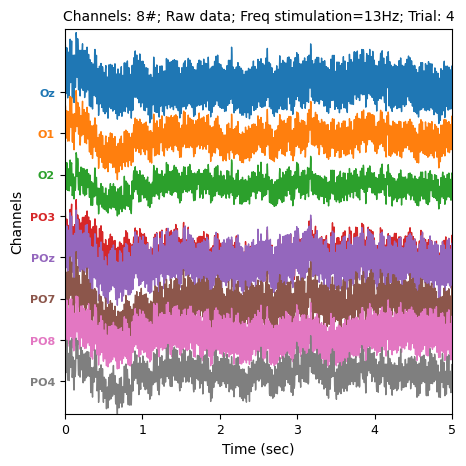

In [15]:
trial = 4          # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
freq_stim = 13     # Define stimulation frequency
title = f'Raw data; Freq stimulation={freq_stim}Hz; Trial: {max(1, trial)}'

# Plot EEG data using the Plot_data.plot_data function
Plot_data.plot_data(data1[:, :, max(0, trial - 1)], fs, channels_name, first_point=0, last_point=1280, val_ylim=2.7, 
                    size_fig=(5, 5), title=title, display_figure="on")  

**Step 3.1: Filtering (** *Filter a trial for one of the stimulation frequencies* **)**<br/>

*Input parameters:*
 - `data:` EEG data to be filtered
 - `f_low:` Lower cutoff frequency of the bandpass filter
 - `f_high:` Upper cutoff frequency of the bandpass filter
 - `order:` Filter order
 - `fs:` Sampling frequency of the EEG data (optional, if not provided, it is assumed to be fs)
 - `type_filter:` Type of filter ('low', 'high', 'bandpass', or 'bandstop') (optional, defaults to 'bandpass')
 - `filter_active:` Filter data using a specific type of filter ('low', 'high', 'bandpass', or 'bandstop') (optional, defaults to 'on')
 - `notch_freq:` Frequency to be removed from signal (Hz)
 - `quality_factor:` Quality factor for notch filter
 - `filter_active:` Whether to activate filtering ("on" or "off")
  - `notch_filter:` Whether to apply a notch filter ("on" or "off")

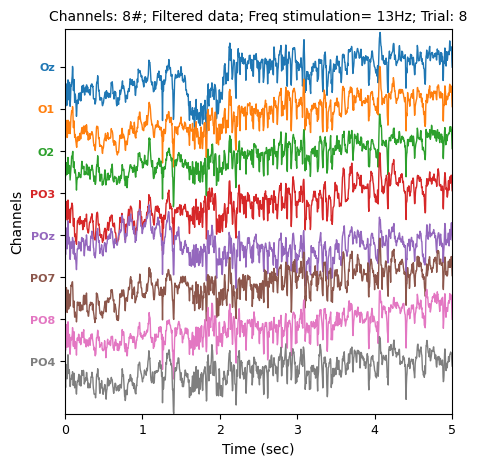

In [20]:
trial = 8            # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
order = 3            # Define filter order
f_low = 0.05         # Define lower cutoff frequency for the bandpass filter (Hz)
f_high = 100         # Define upper cutoff frequency for the bandpass filter (Hz)
notch_freq = 50      # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20  # Define quality factor for the notch filter
notch_filter = "on"  # on or off
filter_active = "on" # on or off
type_filter = "bandpass"  # low, high, bandpass, or bandstop
freq_stim = 13       # Define stimulation frequency
title = f'Filtered data; Freq stimulation= {freq_stim}Hz; Trial: {max(1, trial)}'

# Apply bandpass filtering to the EEG data using the Filtering.filtering function
filtered_data = Filtering.filtering(data1, f_low, f_high, order, fs, notch_freq, quality_factor, filter_active,
                                    notch_filter, type_filter)
Plot_data.plot_data(filtered_data[:, :, max(0, trial - 1)], fs, channels_name, first_point=0, last_point=1280, 
                    val_ylim=2.7, size_fig=(5, 5), title=title, display_figure="on")

**Step 3.2: Fourier transform** **(** *FFT a channel for one of the stimulation frequencies* **)**

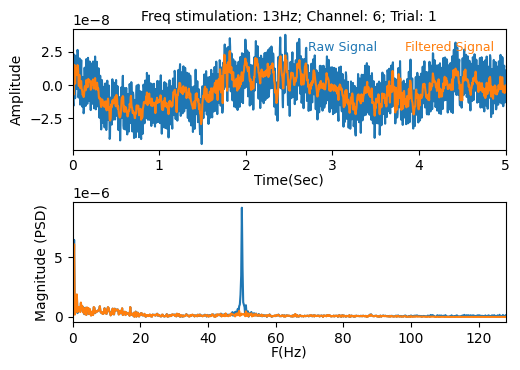

In [21]:
trial = 0          # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
channel = 6        # Define channel (trial 1 in Python index starts from 0, so channel 1 means index 0)
freq_stim = 13     # Define stimulation frequency
title = f"Freq stimulation: {freq_stim}Hz; Channel: {max(1, channel)}; Trial: {max(1, trial)}"

FFT.fft_analysis(data1, filtered_data, fs, channel, trial, title, size_fig=[5, 3.5])

**Step 3.3: CAR filter** **(** *CAR a trial for one of the stimulation frequencies* **)**<br/>

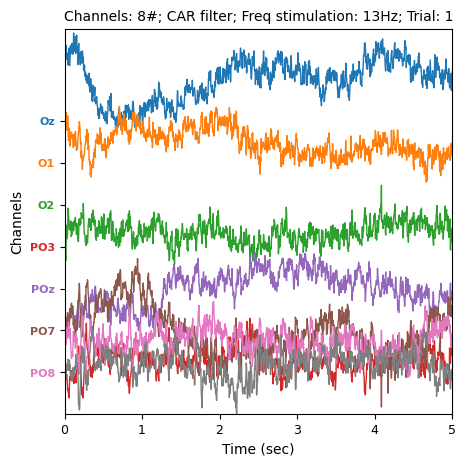

In [57]:
trial = 0          # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
freq_stim = 13     # Define stimulation frequency
title = f"CAR filter; Freq stimulation: {freq_stim}Hz; Trial: {max(1, trial)}"

# Apply common average reference (CAR) to the EEG data using the Common_average_reference.car function
data_car = Common_average_reference.car(filtered_data) 
Plot_data.plot_data(data_car[:, :, max(0, trial - 1)], fs, channels_name, first_point=0, last_point=1280, val_ylim\
                    =2.7, size_fig=(5, 5), title=title, display_figure="on")

**Step 4.1: Power Spectral Density Analysis (PSDA)** **(** *PSDA a channel & a trial for one of the stimulation frequencies* **)**<br/>
[Article 1](https://www.researchgate.net/profile/Javier-Castillo-27/publication/263618753_Feature_Extraction_Techniques_Based_on_Power_Spectrum_for_a_SSVEP-BCI/links/5527b5a60cf29b22c9b937bd/Feature-Extraction-Techniques-Based-on-Power-Spectrum-for-a-SSVEP-BCI.pdf)<br/>
[Article 2](https://www.researchgate.net/publication/301341524_EEG_Signal_Analysis_Methods_Based_on_Steady_State_Visual_Evoked_Potential_Stimuli_for_the_Development_of_Brain_Computer_Interfaces_A_Review_Address_for_Correspondence)<br/>
$S_k = 10 \log_{10} \left( \frac{nP(f_k)}{\sum_{m=1}^{n/2} \left[P(f + mf_{res}) + P(f - mf_{res})\right]} \right)$<br/>
where `n` is the number of points near at the frequency stimulus, `P(fk)` is the power density of the stimulus frequencies and `fres `is the resolution frequency, which depends on the number of samples used in the Fourier transform. `P(fk + mfres)` and `P(fk −mfres) `are power densities around the target frequency.

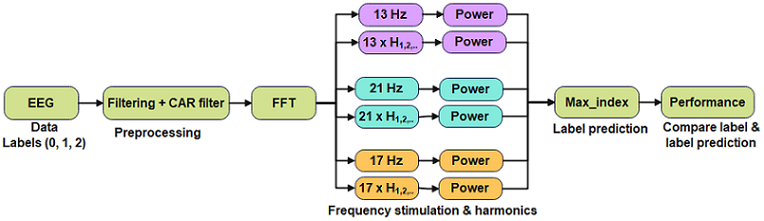

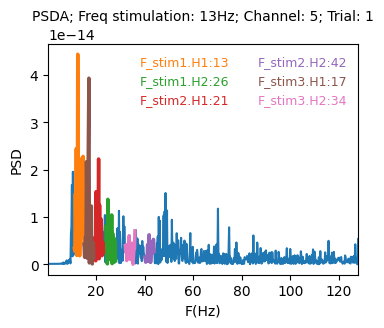

In [44]:
# ------------------------- Step 1: Filtering for one of the stimulation frequencies -------------------------------
trial = 8                # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
order = 3                # Define filter order
f_low = 0.05             # Define lower cutoff frequency for the bandpass filter (Hz)
f_high = 13 -1           # Define upper cutoff frequency for the bandpass filter (Hz) (min(f_stim) - 1)
notch_freq = 50          # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20      # Define quality factor for the notch filter
notch_filter = "on"      # on or off
filter_active = "on"     # on or off
type_filter = "high"     # low, high, bandpass, or bandstop

# Apply high filtering to the EEG data using the Filtering.filtering function
filtered_data = Filtering.filtering(data1, f_low, f_high, order, fs, notch_freq, quality_factor, filter_active,
                                    notch_filter, type_filter)
# ----------------------------- Step 2: CAR for one of the stimulation frequencies----------------------------------
data_car = Common_average_reference.car(filtered_data)
# --------------------------- Step 3: PSDA for one of the stimulation frequencies-----------------------------------
trial = 0              # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
channel = 5            # Define channel (trial 1 in Python index starts from 0, so channel 1 means index 0)
freq_stim = 13         # Define stimulation frequency
num_harmonic = 2       # Number of harmonic for each frequency stimulation
num_sample_neigh = 20  # Number of samples neighborhood for each frequency stimulation
f_stim = [13, 21, 17]  # Frequencies stimulation
title = f"PSDA; Freq stimulation: {freq_stim}Hz; Channel: {max(1, channel)}; Trial: {max(1, trial)}"

max_freq, label = PSDA_a_trial.psda_a_trial(data_car[:, max(0, channel - 1), max(0, trial - 1)], fs, num_sample_neigh, 
                                            f_stim, num_harmonic, title, fig_size=[4, 3])

**Step 4.2: Power Spectral Density Analysis (PSDA) for all datasets or stimulations**<br/>

In [46]:
# ------------------------------------- Step 1: Combine all of datasets --------------------------------------------
data_total = np.concatenate((data1, data2, data3), axis=2)
labels = np.concatenate((np.full(data1.shape[-1], 0), np.full(data1.shape[-1], 1), np.full(data1.shape[-1], 2)))
# ------------------------------------ Step 2: Filtering for all of datasets ---------------------------------------
order = 3                # Define filter order
f_low = 0.05             # Define lower cutoff frequency for the bandpass filter (Hz)
f_high = 100             # Define upper cutoff frequency for the bandpass filter (Hz)
notch_freq = 50          # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20      # Define quality factor for the notch filter
notch_filter = "on"      # on or off
filter_active = "off"    # on or off
type_filter = "bandpass" # low, high, bandpass, or bandstop

# Apply notch filter to the EEG data using the Filtering.filtering function
filtered_data = Filtering.filtering(data_total, f_low, f_high, order, fs, notch_freq, quality_factor, filter_active,
                                    notch_filter, type_filter)
# --------------------------------------- Step 3: CAR for all of datasets ------------------------------------------
data_car = Common_average_reference.car(filtered_data) 
# -------------------------------------- Step 4: PSDA for all of datasets ------------------------------------------
num_channel = [0, 1, 2]   # Number of Channel          
num_harmonic = 2          # Number of harmonic for each frequency stimulation
num_sample_neigh = 30     # Number of samples neighborhood for each frequency stimulation
f_stim = [13, 21, 17]     # Frequencies stimulation

predict_label = PSDA_all_trial.psda_all_trial(data_car[:, num_channel], f_stim, num_sample_neigh, fs, num_harmonic)
print(f"Accuracy: {np.sum(labels == predict_label) / len(predict_label) * 100:.2f}")

Accuracy: 94.79


**Step 5: Canonical correlation analysis (CCA) Method**<br/>
[Article 1](https://graphics.stanford.edu/courses/cs233-18-spring/ReferencedPapers/CCA_Weenik.pdf)<br/>
[Article 2](https://ieeexplore.ieee.org/abstract/document/4015614)<br/>
[Article 3](https://www.frontiersin.org/articles/10.3389/fninf.2016.00049/full)<br/>
CCA is a statistical technique used to find correlations between two sets of data (EEG signals from different channels and sinusoidal signals at the stimulation frequencies and their harmonics). It aims to identify the linear relationships between variables in each set and determine the maximum correlation between linear combinations of variables from the two sets.<br/>

`CCA step by step:`
- Step 1: Generate sine and cosine waves for the fundamental and harmonic frequencies for each stimulus frequency to create the reference signal set Y.
- Step 2: Calculate the covariance matrices (EEG & Yref) 
- Step 3: Perform singular value decomposition on the covariance matrices or the data sets.
- Step 4: Obtain the singular values and singular vectors from the decomposition.
- Step 5: Calculate the canonical correlation coefficients using the singular values.
- Step 6: Interpret the canonical correlation coefficients to understand the relationships between the variables in each set.



In [51]:
import numpy as np

# ==================================== Canonical Correlation Analysis (CCA) ========================================
def cca_analysis(data, data_ref):
    """
    Canonical Correlation Analysis (CCA)
    :param data: numpy array of data
    :param data_ref: numpy array of reference data
    :return: numpy array of optimum canonical correlations
    """
    # Combine the data and reference data based on their dimensionality
    xy = np.concatenate((data, data_ref), axis=1) if data.shape[1] <= data_ref.shape[1] else np.concatenate\
        ((data_ref, data), axis=1)
    
    # Calculate covariance matrices
    covariance = np.cov(xy, rowvar=False)
    n = min(data.shape[1], data_ref.shape[1])
    cx = covariance[:n, :n]
    cy = covariance[n:, n:]
    cxy = covariance[:n, n:]
    cyx = covariance[n:, :n]
    
    # Solve the optimization problem using eigenvalue decomposition
    # Adding np.eye(*cy.shape) * eps ensures numerical stability
    eps = np.finfo(float).eps
    corr_coef = np.linalg.inv(cy + np.eye(*cy.shape) * eps) @ cyx @ np.linalg.inv(cx + np.eye(*cx.shape) * eps) @ cxy
    
    # Eigenvalue decomposition and sorting
    eig_vals = np.linalg.eigvals(corr_coef)
    
    # Set any small negative eigenvalues to zero, assuming they are due to numerical error
    eig_vals[eig_vals < 0] = 0
    d_coeff = np.sqrt(np.sort(np.real(eig_vals))[::-1])  # Only real parts, sorted in descending order
    
    return d_coeff[:n]  # Return the canonical correlations

In [52]:
def acc(data, fs, f_stim, num_channel, num_harmonic):
    
    """
    ================================================================================================================
    """
    # ----------------------------- Convert data to ndarray if it's not already ------------------------------------
    data = np.array(data) if not isinstance(data, np.ndarray) else data

    # Transpose the data if it has more than one dimension and has fewer rows than columns
    data = data.T if data.ndim > 1 and data.shape[0] < data.shape[-1] else data
    # ------------------------------------------ Reference signal --------------------------------------------------
    data_ref = []
    time = np.arange(0, data.shape[0]) / fs  # Time vector

    for _, val in enumerate(f_stim): # First loop: frequencies stimulation

        signal_ref = []

        for j in range(1, num_harmonic + 1):  # Generate a reference signal for each frequency stimulation
            signal_ref.append(np.sin(2 * np.pi * j * val * time))
            signal_ref.append(np.cos(2 * np.pi * j * val * time))

        data_ref.append(np.stack(signal_ref, axis=1))  # Store data_ref in the data_ref_list
    # # ----------------------------------------- Correlation Analysis ---------------------------------------------
    # label_predic = np.zeros(data.shape[-1])  # Initialize label_predic array with zeros
    # for i in range(data.shape[-1]): # Loop through all Trials
    #     s = np.zeros(len(f_stim))
    
    #     for k in range(len(f_stim)):  # Second loop: Calculate CCA for frequencies stimulation
    #         cano_corr = cca_analysis(data[:, num_channel, i], data_ref[k])
    #         s[k] = np.max(cano_corr)
        
    #     label_predic[i] = np.argmax(s) # Predict label for the current trial
    
    return data_ref

In [55]:
# ------------------------------------- Step 1: Combine all of datasets --------------------------------------------
data_total = np.concatenate((data1, data2, data3), axis=2)
labels = np.concatenate((np.full(data1.shape[-1], 0), np.full(data1.shape[-1], 1), np.full(data1.shape[-1], 2)))
# ------------------------- Step 1: Filtering for one of the stimulation frequencies -------------------------------
trial = 8                # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
order = 3                # Define filter order
f_low = 0.05             # Define lower cutoff frequency for the bandpass filter (Hz)
f_high = 100             # Define upper cutoff frequency for the bandpass filter (Hz)
notch_freq = 50          # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20      # Define quality factor for the notch filter
notch_filter = "on"      # on or off
filter_active = "off"    # on or off
type_filter = "bandpass" # low, high, bandpass, or bandstop

# Apply notch filter to the EEG data using the Filtering.filtering function
filtered_data = Filtering.filtering(data3, f_low, f_high, order, fs, notch_freq, quality_factor, filter_active,
                                    notch_filter, type_filter)
# ----------------------------- Step 2: CAR for one of the stimulation frequencies----------------------------------
data_car = Common_average_reference.car(filtered_data)
# --------------------------------------------- Step 3: CCA Method -------------------------------------------------
num_harmonic = 2          # Number of harmonic for each frequency stimulation
f_stim = [13, 21, 17]     # Frequencies stimulation
num_channel = [0, 1, 2]   # Number of Channel          

data = data_car
# data_ref = []
# time = np.arange(0, data.shape[0]) / fs  # Time vector
   
# for _, val in enumerate(f_stim): # First loop: frequencies stimulation
    
#     signal_ref = []

#     for j in range(1, num_harmonic + 1):  # Generate a reference signal for each frequency stimulation
#         signal_ref.append(np.sin(2 * np.pi * j * val * time))
#         signal_ref.append(np.cos(2 * np.pi * j * val * time))

#     data_ref.append(np.stack(signal_ref, axis=1))  # Store data_ref in the data_ref_list
data_ref = acc(data, fs, f_stim, num_channel, num_harmonic)
# ------------------------------------------ Correlation Analysis -------------------------------------------------
f_ref = np.zeros(len(f_stim))

for i, val in enumerate(f_stim):  # First loop for frequencies stimulation
    cano_corr = cca_analysis(data[:, num_channel, 158], data_ref[i])
    f_ref[i] = np.max(cano_corr)
label_predic = np.argmax(f_ref)
label_predic

2

In [ ]:
# ------------------------------------ Step 1: Combine all of datasets --------------------------------------------
data_total = np.concatenate((data1, data2, data3), axis=2)
labels = np.concatenate((np.full(data1.shape[-1], 0), np.full(data1.shape[-1], 1), np.full(data1.shape[-1], 2)))
# ----------------------------------- Step 2: Filtering for all of datasets ---------------------------------------
order = 3                # Define filter order
f_low = 0.05             # Define lower cutoff frequency for the bandpass filter (Hz)
f_stim = [13, 21, 17]    # Frequencies stimulation
f_high = 100             # Define upper cutoff frequency for the bandpass filter (Hz)
notch_freq = 50          # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20      # Define quality factor for the notch filter
notch_filter = "on"      # on or off
filter_active = "off"    # on or off
type_filter = "bandpass" # low, high, bandpass, or bandstop

# Apply notch filter to the EEG data using the Filtering.filtering function
filtered_data = Filtering.filtering(data_total, f_low, f_high, order, fs, notch_freq, quality_factor, filter_active,
                                    notch_filter, type_filter)
# -------------------------------------- Step 3: CAR for all of datasets ------------------------------------------
data_car = Common_average_reference.car(filtered_data) 
# -------------------------------------- Step 4: CCA for all of datasets ------------------------------------------
num_channel = [0, 1, 2]   # Number of Channel          
num_harmonic = 2          # Number of harmonic for each frequency stimulation



In [29]:
# ------------------------ Step 1: Filtering for one of the stimulation frequencies -------------------------------
trial = 8                # Define trial number (trial 1 in Python index starts from 0, so trial 1 means index 0)
order = 3                # Define filter order
f_low = 0.05             # Define lower cutoff frequency for the bandpass filter (Hz)
f_stim = [13, 21, 17]    # Frequencies stimulation
f_high = 100             # Define upper cutoff frequency for the bandpass filter (Hz)
notch_freq = 50          # Define frequency to be removed from the signal for notch filter (Hz)
quality_factor = 20      # Define quality factor for the notch filter
notch_filter = "on"      # on or off
filter_active = "off"    # on or off
type_filter = "bandpass" # low, high, bandpass, or bandstop

# Apply notch filter to the EEG data using the Filtering.filtering function
filtered_data = Filtering.filtering(data3, f_low, f_high, order, fs, notch_freq, quality_factor, filter_active,
                                    notch_filter, type_filter)
# ---------------------------- Step 2: CAR for one of the stimulation frequencies----------------------------------
data_car = Common_average_reference.car(filtered_data)
# -------------------------------------------- Step 3: CCA Method -------------------------------------------------
num_channel = [0, 1, 2]   # Number of Channel          
num_harmonic = 2          # Number of harmonic for each frequency stimulation
f_ref = np.zeros(len(f_stim))
time = np.arange(0, data_car.shape[0]) / fs  # Time vector

for i, val in enumerate(f_stim):  # First loop for frequencies stimulation
    signal_ref = []
    
    # Second loop creates a reference signal for each frequency stimulation
    for j in range(1, num_harmonic + 1):  
        signal_ref.append(np.sin(2 * np.pi * j * val * time))
        signal_ref.append(np.cos(2 * np.pi * j * val * time))

    data_ref = np.stack(signal_ref, axis=1)   
    cano_corr = cca_analysis(data_car[:, num_channel, 158], data_ref)
    
    f_ref[i] = np.max(cano_corr)
label_predic = np.argmax(f_ref)
label_predic

2

In [173]:
def acc1(data, fs, f_stim, num_channel, num_harmonic):
    # ----------------------------------------- Reference signal --------------------------------------------------
    data_ref = []
    time = np.arange(0, data.shape[0]) / fs  # Time vector
   
    for _, val in enumerate(f_stim): # First loop: frequencies stimulation
        
        signal_ref = []

        for j in range(1, num_harmonic + 1):  # Generate a reference signal for each frequency stimulation
            signal_ref.append(np.sin(2 * np.pi * j * val * time))
            signal_ref.append(np.cos(2 * np.pi * j * val * time))

        data_ref.append(np.stack(signal_ref, axis=1))  # Store data_ref in the data_ref_list
    # ----------------------------------------- Correlation Analysis ----------------------------------------------
    label_predic = np.zeros(data.shape[-1])  # Initialize label_predic array with zeros
    for i in range(data.shape[-1]): # Loop through all Trials
        s = np.zeros(len(f_stim))
    
        for k in range(len(f_stim)):  # Second loop: Calculate CCA for frequencies stimulation
            cano_corr = cca_analysis(data[:, num_channel, i], data_ref[k])
            s[k] = np.max(cano_corr)
        
        label_predic[i] = np.argmax(s) # Predict label for the current trial
    
    return label_predic


label_predic = acc(data_car, fs, f_stim, num_channel, num_harmonic)
print(f"Accuracy: {np.sum(labels == predict_label) / len(predict_label) * 100:.2f}")

Accuracy: 94.79
